# Node Embeddings

Here we will have a look at node embeddings and how to further reduce their dimensionality to be able to visualize them in a 2D plot. 

### Note about data dependencies

PageRank centrality and Leiden community are also fetched from the Graph and need to be calculated first.
This makes it easier to see in the visualization if the embeddings approximate the structural information of the graph.
If these properties are missing you will only see black dots all of the same size without community coloring.
In future it might make sense to also run a community detection algorithm co-located in here to not depend on the order of execution.

<br>  

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)
- [Tutorial: Applied Graph Embeddings](https://neo4j.com/developer/graph-data-science/applied-graph-embeddings)
- [Visualizing the embeddings in 2D](https://github.com/openai/openai-cookbook/blob/main/examples/Visualizing_embeddings_in_2D.ipynb)
- [Fast Random Projection](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp)
- [scikit-learn TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)
- [AttributeError: 'list' object has no attribute 'shape'](https://bobbyhadz.com/blog/python-attributeerror-list-object-has-no-attribute-shape)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
import typing as typ
import numpy as np
from sklearn.manifold import TSNE
from neo4j import GraphDatabase

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))


The scikit-learn version is 1.3.0.
The pandas version is 1.5.1.


In [3]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [4]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [5]:
def query_cypher_to_data_frame(filename, parameters_: typ.Optional[typ.Dict[str, typ.Any]] = None):
    records, summary, keys = driver.execute_query(get_cypher_query_from_file(filename),parameters_=parameters_)
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [6]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [7]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [8]:
# Main Colormap
main_color_map = 'nipy_spectral'

## Preparation

### Create Graph Projection

Create an in-memory undirected graph projection containing Package nodes (vertices) and their dependencies (edges).

In [9]:
package_embeddings_parameters={
    "dependencies_projection": "package-embeddings-notebook",
    "dependencies_projection_node": "Package",
    "dependencies_projection_weight_property": "weight25PercentInterfaces",
    "dependencies_projection_wright_property": "nodeEmbeddingsFastRandomProjection",
    "dependencies_projection_embedding_dimension":"64" 
}

In [10]:
query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_1_Delete_Projection.cypher", package_embeddings_parameters)
query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_2_Delete_Subgraph.cypher", package_embeddings_parameters)
query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_4_Create_Undirected_Projection.cypher", package_embeddings_parameters)
query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_5_Create_Subgraph.cypher", package_embeddings_parameters)

,graphName,fromGraphName,nodeCount,relationshipCount,nodeFilter
0,package-embeddings-notebook-cleaned,package-embeddings-notebook,93,690,n.outgoingDependencies > 0 OR n.incomingDepend...


### Generate Node Embeddings using Fast Random Projection (Fast RP)

[Fast Random Projection](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp) calculates an array of floats (length = embedding dimension) for every node in the graph. These numbers approximate the relationship and similarity information of each node and are called node embeddings. Random Projections is used to reduce the dimensionality of the node feature space while preserving pairwise distances.

The result can be used in machine learning as features approximating the graph structure. It can also be used to further reduce the dimensionality to visualize the graph in a 2D plot, as we will be doing here.

In [11]:

fast_random_projection = query_cypher_to_data_frame("../cypher/Node_Embeddings/Node_Embeddings_1d_Fast_Random_Projection_Stream.cypher", package_embeddings_parameters)
fast_random_projection.head() # Look at the first entries of the table 


,codeUnitName,communityId,centrality,artifactName,embedding
0,org.axonframework.disruptor.commandhandling,0,0.016234,axon-disruptor-4.9.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,org.axonframework.modelling.command,1,0.155609,axon-modelling-4.9.1,"[0.143403097987175, 0.0, 0.2635873258113861, 0..."
2,org.axonframework.modelling.command.inspection,1,0.152740,axon-modelling-4.9.1,"[0.1585913896560669, 0.0, 0.24182039499282837,..."
3,org.axonframework.modelling.command.legacyjpa,1,0.016234,axon-modelling-4.9.1,"[0.18532788753509521, 0.0, 0.2633548080921173,..."
4,org.axonframework.modelling.saga,2,0.349429,axon-modelling-4.9.1,"[-0.0880851000547409, -0.1873326301574707, 0.0..."


### Dimensionality reduction with t-distributed stochastic neighbor embedding (t-SNE)

This step takes the original node embeddings with a higher dimensionality (e.g. list of 32 floats) and
reduces them to a 2 dimensional array for visualization. 

> It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

(see https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)

In [12]:
# Calling the fit_transform method just with a list doesn't seem to work (anymore?). 
# It leads to an error with the following message: 'list' object has no attribute 'shape'
# This can be solved by converting the list to a numpy array using np.array(..).
# See https://bobbyhadz.com/blog/python-attributeerror-list-object-has-no-attribute-shape
embeddings_as_numpy_array = np.array(fast_random_projection.embedding.to_list())

# Use TSNE to reduce the dimensionality of the previous calculated node embeddings to 2 dimensions for visualization
t_distributed_stochastic_neighbor_embedding = TSNE(n_components=2, verbose=1, random_state=50)
two_dimension_node_embeddings = t_distributed_stochastic_neighbor_embedding.fit_transform(embeddings_as_numpy_array)
two_dimension_node_embeddings.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.000s...
[t-SNE] Computed neighbors for 93 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.561666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.551247
[t-SNE] KL divergence after 1000 iterations: 0.109627


(93, 2)

In [13]:
# Create a new DataFrame with the results of the 2 dimensional node embeddings
# and the code unit and artifact name of the query above as preparation for the plot
node_embeddings_for_visualization = pd.DataFrame(data = {
    "codeUnit": fast_random_projection.codeUnitName,
    "artifact": fast_random_projection.artifactName,
    "communityId": fast_random_projection.communityId,
    "centrality": fast_random_projection.centrality,
    "x": [value[0] for value in two_dimension_node_embeddings],
    "y": [value[1] for value in two_dimension_node_embeddings]
})
node_embeddings_for_visualization.head()

,codeUnit,artifact,communityId,centrality,x,y
0,org.axonframework.disruptor.commandhandling,axon-disruptor-4.9.1,0,0.016234,-7.240916,-0.522233
1,org.axonframework.modelling.command,axon-modelling-4.9.1,1,0.155609,-5.696959,-2.337914
2,org.axonframework.modelling.command.inspection,axon-modelling-4.9.1,1,0.152740,-5.673934,-2.349451
3,org.axonframework.modelling.command.legacyjpa,axon-modelling-4.9.1,1,0.016234,-5.659551,-2.362605
4,org.axonframework.modelling.saga,axon-modelling-4.9.1,2,0.349429,-10.506205,0.499171


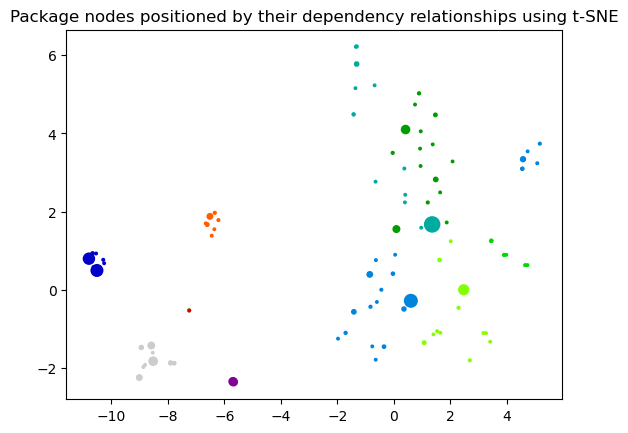

In [14]:
plot.scatter(
    x=node_embeddings_for_visualization.x,
    y=node_embeddings_for_visualization.y,
    s=node_embeddings_for_visualization.centrality * 200,
    c=node_embeddings_for_visualization.communityId,
    cmap=main_color_map,
)
plot.title("Package nodes positioned by their dependency relationships using t-SNE")
plot.show()